# Fake News Detection

**Author**: Marcelo Scatena
***
March 2022

<img src='./images/The_fin_de_siecle_newspaper_proprietor.jpg' width=1000 align='left'/>

[Image Source](https://en.wikipedia.org/wiki/Fake_news#/media/File:The_fin_de_si%C3%A8cle_newspaper_proprietor_(cropped).jpg)

# Table of Contents
* [Overview](#Overview)
* [Business Problem](#Business_Problem)
* [Data Understanding](#Data_Understanding)
* [I. Data Exploration](#Data_Exploration)
    * [Text Preprocessing](#Text_Preprocessing)
    * [Word Clouds](#Wordclouds)
* [II. Data Modeling](#Data_Modeling)    
    * [Classification Models](#Classification)
    * [Embedding Models](#Embedding)
    * [LDA](#LDA)
* [III. Final Model](#Final_Model)
* [IV. Results](#Results)
* [Next Steps](#Next_Steps)
* [Contact](#Contact)

# Overview <a class="anchor" id="Overview"></a>
Fake news has become increasingly more common in the past decades. It's effectiveness cannot be misjudged, as it can aid people in not taking responsability, in winning arguments or, in a bigger scale, elections. In 2016 hundreds of teenagers in Europe were hired to write false stories about the US election, as this [BBC article](https://www.bbc.co.uk/news/magazine-38168281) unveils. Their stories would be retweeted, shared on social media or via direct message hundreds and thousands of times, reaching millions of people. It's hard to quantify how much those stories could influence an outcome, but nearing the end of the election, fake news had a higher engagement count than mainstream news.<br />
Stories like this are not only recent though. One can easily look at las century history when some say [Hitler Pioneered 'Fake News'](https://www.nytimes.com/2019/10/16/opinion/hitler-speech-1919.html), but this has happened for milenia, with counts in 1274 bce, where Ramses's II accounts of [The Battle of Kadesh](https://www.ingeniahistory.com/post/the-battle-of-kadesh) have been gravely misconstruded.<br />
Nowadays this problem is even more pressing given the amount of misinformation coming from articles and stories regarding the russian war.

# Business Problem <a class="anchor" id="Business_problem"></a>
Detecting fake news is a very challenging task. If the platform where it is being broadcasted can be biased, and one simply can't have access to the source material, how can you attest to it's truthness? We also have to take into consideration that out of those fake news, some of them could have been written as parody, some completely fabricated, some manipulated or making false connections. The biggest difficulty regarding this topic is that fake news are ment to be decieving. They're pursposely written to sound convincing and appear to be true. Humans have a hard time distinguishing from true or fake even with all our world understanding and contextualized analysis. The objective of this study is to see if machine learning can help us with that process.<br />
To better understand how to assess if a piece news is fake or true, I'll be using Natural Language Processing.<br />
- My primary evaluation metric will be Accuracy, since the goal is to label correctly the largest amount of news. As a secondary metric I'll look at Precision, since classifying as True a piece of news that is False (False Positive) can be more damaging than the other way around.

# Data Understanding <a class="anchor" id="Data_Understanding"></a>
With the idea of trying to improve fake news classification, the LIAR dataset was created in 2017, containing 12.8 thousand manually labeled short statements from the last decade gathered from PolitiFact.com, which provides detailed analysis report and links to source document to each case. This is the most accuratly labeled dataset on the subject and became a benchmark for it.<br />
The data consists of 12.8k rows with 14 different features containing: Statement ID, Label, Statement, Speaker, Speaker's job title, State, Speaker's party affiliation, the statement credit count (from pants on fire to true), Venue or Location of statement and the Justification for the labeling. I'll explore all the metadata but will create my models using only the 'statement' and 'label' features, since I want to see if the models can be used in broader situations.<br />
[Link](https://github.com/Tariq60/LIAR-PLUS) to dataset.

# I. Data Exploration <a class="anchor" id="Data_Exploration"></a>
To start with, we load the dataset and explore its values.

In [204]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np

#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

#Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re

#Data Modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Data Evaluation 
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate , GridSearchCV, RandomizedSearchCV

# Neural Networks
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import ModelCheckpoint

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

In [2]:
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
raw_train = pd.read_csv('data/train2.tsv', sep='\t', names=col_names)
raw_test = pd.read_csv('data/test2.tsv', sep='\t', names=col_names)
raw_val = pd.read_csv('data/val2.tsv', sep='\t', names=col_names)

In [3]:
raw_train.head()

,ID,label,statement,subject,speaker,speaker's title,state,party,barely true,false,half true,mostly true,pants on fire,context,justification
0.0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [7]:
raw_train['label'].value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64

In [8]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10242 entries, 0.0 to 10268.0
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   speaker's title  7343 non-null   object 
 6   state            8032 non-null   object 
 7   party            10238 non-null  object 
 8   barely true      10238 non-null  float64
 9   false            10238 non-null  float64
 10  half true        10238 non-null  float64
 11  mostly true      10238 non-null  float64
 12  pants on fire    10238 non-null  float64
 13  context          10138 non-null  object 
 14  justification    10154 non-null  object 
dtypes: float64(5), object(10)
memory usage: 1.3+ MB


In [11]:
raw_train.isna().sum()

ID                    2
label                 2
statement             2
subject               4
speaker               4
speaker's title    2899
state              2210
party                 4
barely true           4
false                 4
half true             4
mostly true           4
pants on fire         4
context             104
justification        88
dtype: int64

We can see some features with lots of missing values, but the Label and Statement features are almost full.

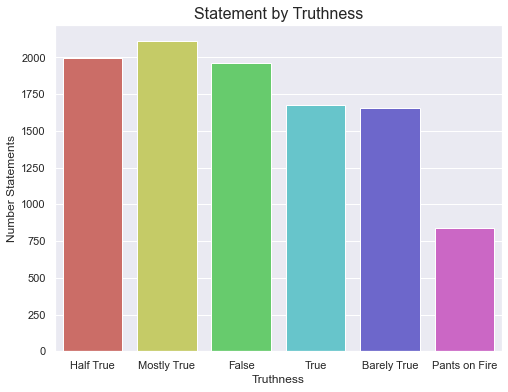

In [30]:
# Visualize the count of classes of target variable
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='label', data=raw_train, palette='hls')
ax.set_title('Statement by Truthness', fontsize=16)
ax.set_xlabel('Truthness', fontsize=12)
ax.set_xticklabels(['Half True', 'Mostly True', 'False', 'True', 'Barely True', 'Pants on Fire'])
ax.set_ylabel('Number Statements', fontsize=12);

Apart from 'Pants on Fire', the data seems to be fairly balanced.

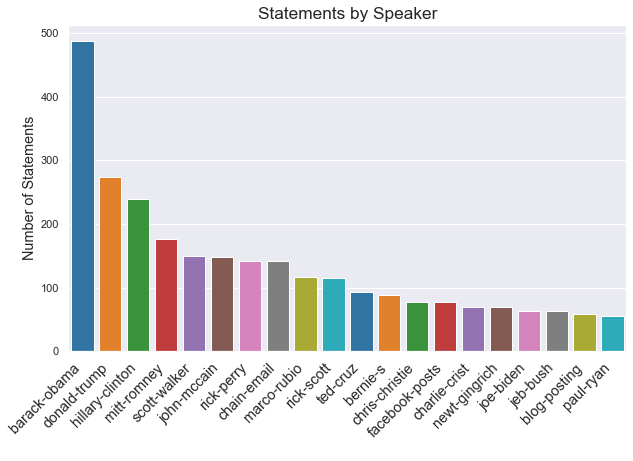

In [45]:
#visualize the counts of statements by speaker

fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=raw_train, 
    x="speaker", order=raw_train["speaker"].value_counts()[:20].index,
    palette='tab10')

ax.set_title('Statements by Speaker', fontsize='x-large')
ax.set_xlabel(' ')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')
ax.set_ylabel('Number of Statements',fontsize='large');

Barack Obaba has the highest number of statements in the dataset, followed by Donald Trump and Hillary Clinton.

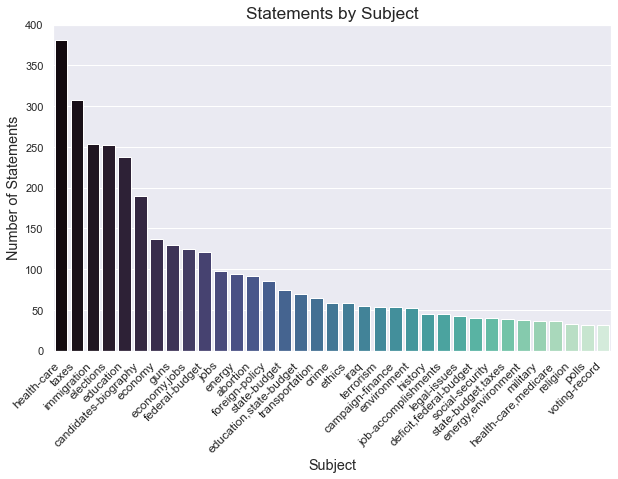

In [26]:
#visualize the counts of statements by Subject

fig, ax = plt.subplots(figsize=(10,6))

top_35_subjects = raw_train['subject'].value_counts()[:35].index.tolist()
ax = sns.countplot(
    data=raw_train, 
    x="subject", order=top_35_subjects,
    palette='mako')

ax.set_title('Statements by Subject', fontsize='x-large')
ax.set_xlabel('Subject',fontsize='large')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')
ax.set_ylabel('Number of Statements',fontsize='large');

Health Care leads as the most talked about subject. It'll be interesting to note if we visualize this information again when performing nlp techniques.

In [280]:
# Create new column measuring the length of statements
raw_train['words'] = raw_train['statement'].apply(lambda x: len(x.split() if type(x)==str else ' '))

In [ ]:
# Cleaning the dataset a bit to be able to execute graph
raw_train_copy = raw_train.copy()
raw_train_copy = raw_train_copy.fillna(' ')
raw_train_copy = raw_train_copy.reset_index(drop=True)
raw_train_copy = raw_train_copy[raw_train_copy['words']<60]
def label(df):
    df['label'] = df['label'].map({'true': 1,
                                     'mostly-true': 1,
                                     'half-true': 1,
                                     'false': 0,
                                     'barely-true': 0,
                                     'pants-fire': 0})
    return df
raw_train_copy = label(raw_train_copy)

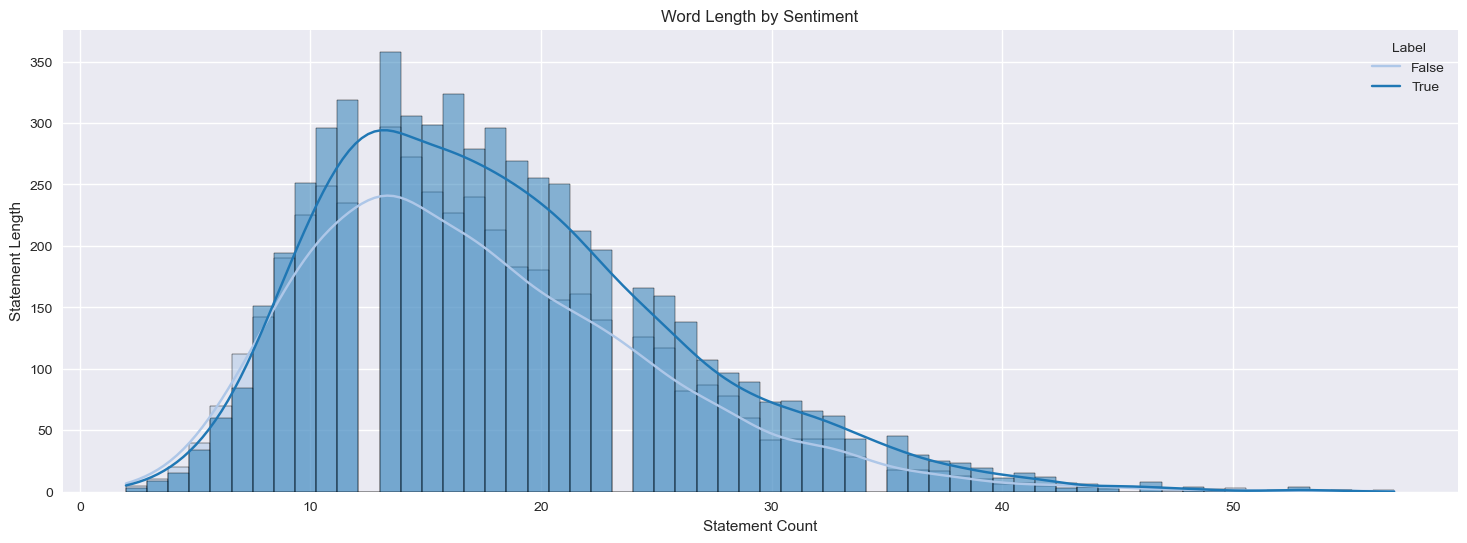

In [302]:
# Visualize the difference between length of true or false statements

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(18, 6))

sns.histplot(x='words', data=raw_train_copy, bins='auto', kde=True, hue='label', legend=True, ax=ax, palette='tab20')
ax.set_title('Word Length by Sentiment')
ax.set_xlabel('Statement Count')
ax.set_ylabel('Statement Length')
ax.legend(['False', 'True'], title='Label')

plt.show()

The distribution of false and true statements seem to follow the same pattern, with peaks occuring at above 250 words. The difference in the distribution might very easily be caused by the fact that we have more True than False statements, So I don't think this can give me any insights for classification.

## Cleaning

To perform Categoral Encoding, the data has to be cleaned in a specific way. All sentences here are lower cased, stripped of stopwords, including additional ones specific for this dataset, other non word characters are removed, as well as punctuation, and the words are lemmetized (remove the inflectional ending of words so they can be classified together). I'll also drop nan values, duplicates, reset the index, and change my labels to binary according to their truthness.

In [4]:
# Drop rows with nan values in the 'statement' feature 
def drop_na(df):
    df = df.dropna(subset=['statement'], axis=0)
    return df

In [5]:
# Drop duplicated rows
def drop_duplicated(df):
    df = df.drop_duplicates()
    return df

In [6]:
# Encode label as binary
def label(df):
    df['label'] = df['label'].map({'true': 1,
                                     'mostly-true': 1,
                                     'half-true': 1,
                                     'false': 0,
                                     'barely-true': 0,
                                     'pants-fire': 0})
    return df

In [7]:
# Lower case, remove stopwords, characters, punctuation and lemmatize words
def clean(text):
    text=text.lower()
    stp=set(stopwords.words("english"))
    stp.update(['say', 'percent', 'state', 'year',
               'said', 'people', 'one'])
    placesp = re.compile('[/(){}\[\]\|@,;]')
    removech= re.compile('[^0-9a-z #+_]')
    st=WordNetLemmatizer()
    text=re.sub(placesp,' ',text)
    text=re.sub(removech,' ',text)
    text=text.split()
    text=[w for w in text if not w in stp]
    text=[st.lemmatize(w) for w in text]
    text=[w for w in text if not w in stp]
    text=" ".join(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

In [8]:
# Runs the above function in each row of dataframe
def clean_df(df):
    df['statement'] = df['statement'].apply(lambda x: clean(x))
    return df

In [9]:
# Drops all features apart from 'statement' and 'label'
def drop_features(df):
    df = df[['statement','label']]
    return df

In [10]:
# Resets index of dataframe
def reset_index(df):
    df = df.reset_index(drop=True)
    return df

In [11]:
# Pipeline to ensure everything goes according to order
cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    ('clean', FunctionTransformer(clean_df)),
    ('drop_features', FunctionTransformer(drop_features)),
    ('reset_index', FunctionTransformer(reset_index))
])

In [12]:
# Clean all datasets
df_train_clean = cleaning_pipeline.fit_transform(raw_train)
df_val_clean = cleaning_pipeline.transform(raw_val)
df_test_clean = cleaning_pipeline.transform(raw_test)

In [13]:
# Creates X variable and y target for all data
X_train_clean = df_train_clean['statement']
y_train_clean = df_train_clean['label']
X_val_clean = df_val_clean['statement']
y_val_clean = df_val_clean['label']
X_test_clean = df_test_clean['statement']
y_test_clean = df_test_clean['label']

In [14]:
df_train_clean.head()

,statement,label
0,annies list political group support third trim...,0
1,decline coal start started natural gas took st...,1
2,hillary clinton agrees john mccain voting give...,1
3,health care reform legislation likely mandate ...,0
4,economic turnaround started end term,1


In [34]:
df_train_clean['label'].value_counts(normalize=True)

0    0.561719
1    0.438281
Name: label, dtype: float64

The target is fairly balanced. I will perform random oversampling in some models, but don't expect it to cause major changes.

## Word Clouds <a class="anchor" id="Wordclouds"></a>

Word clouds are a visual display of the data fed to them. The bigger a word appear in them, the more common it appears in the data.<br />
The first one I'll generate is using all the statements in the train data.

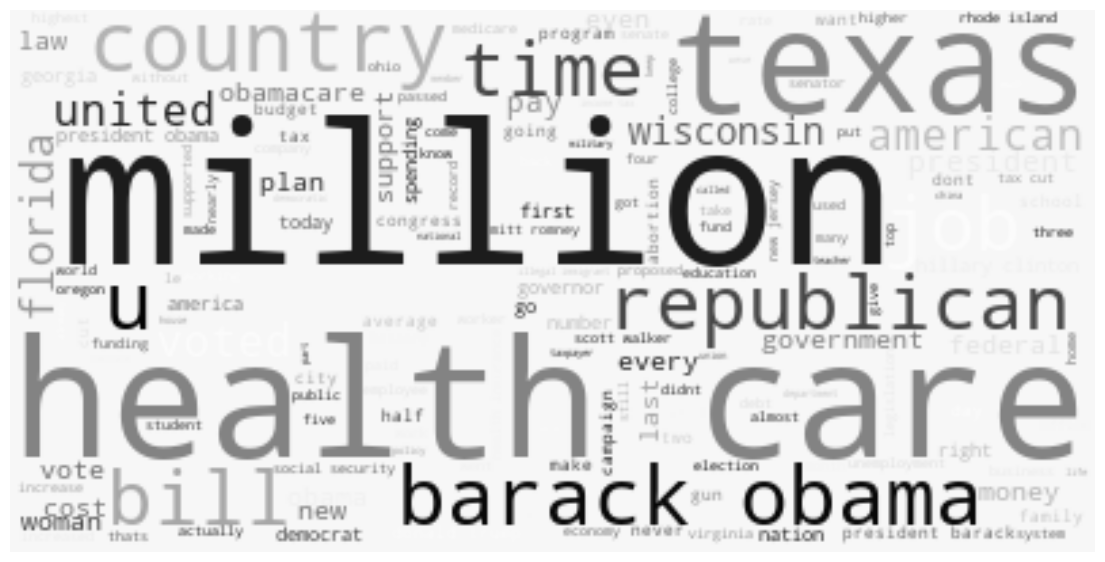

In [308]:
text = ' '.join(df_train_clean['statement'])

# Create and generate a word cloud image:
plt.figure(figsize=(14,10))
wordcloud = WordCloud(background_color='#f7f7f7', colormap='Greys_r', random_state=1).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

Below we see the word cloud consisting of all the words in statements in the train data that have been labeled as True.

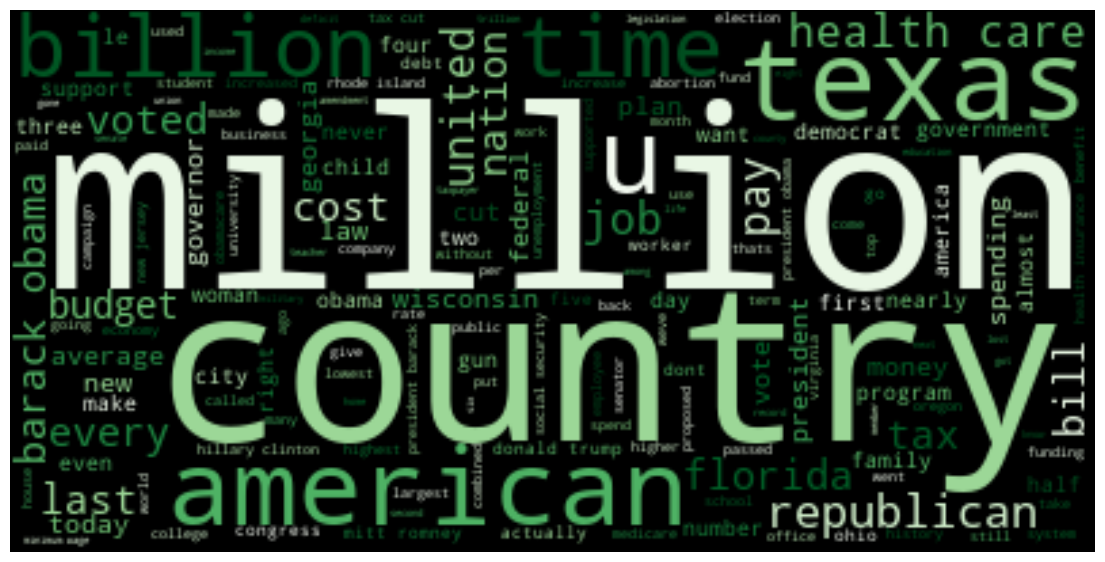

In [306]:
text = ' '.join(df_train_clean[df_train_clean['label']==0]['statement'])

# Create and generate a word cloud image:
plt.figure(figsize=(14,10))
wordcloud = WordCloud(background_color='Black', colormap='Greens', random_state=1).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

Below we see the word cloud consisting of all the words in statements in the train data that have been labeled as False.

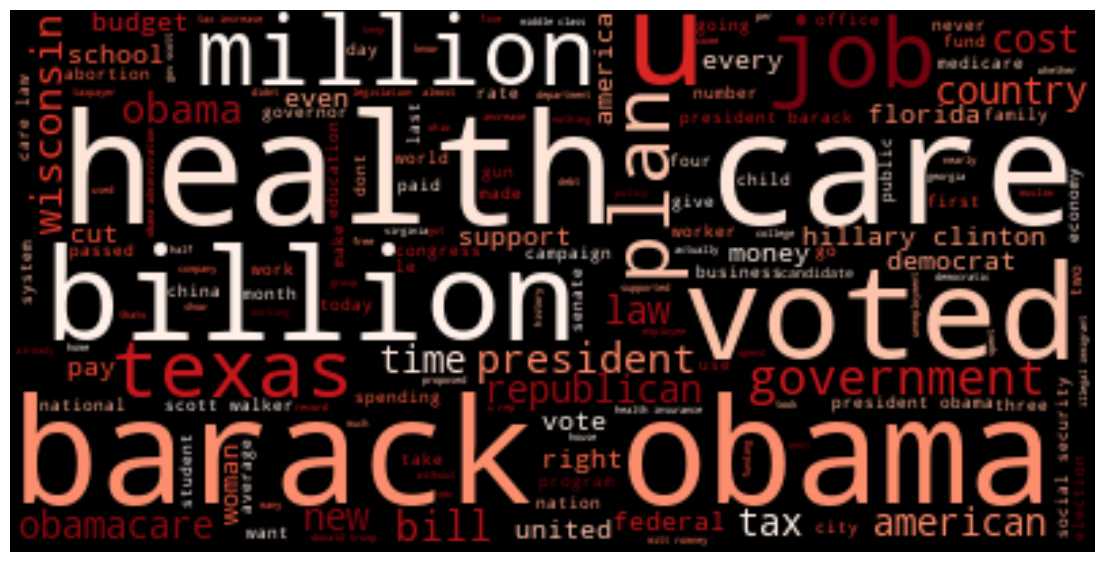

In [307]:
text = ' '.join(df_train_clean[df_train_clean['label']==1]['statement'])

# Create and generate a word cloud image:
plt.figure(figsize=(14,10))
wordcloud = WordCloud(background_color='Black', colormap='Reds', random_state=1).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

There isn't much to be gained from trying to analyse these clouds given this dataset and what it's trying to classify. I'll perform other techniques for word and feature extractions throughout the notebook.

# II. Data Modeling <a class="anchor" id="Data_Modeling"></a>

Create pipelines and helper functions to train several models at the same time.<br />
The first models will use CountVectorizer as their vectorizer.

In [21]:
mnb = Pipeline([('Vectorizer', CountVectorizer()),
               ('mnb', MultinomialNB())])

lr = Pipeline([('Vectorizer', CountVectorizer()),
               ('LogisticReg', LogisticRegression())])

dtc = Pipeline([('Vectorizer', CountVectorizer()),
               ('DecisionTree', DecisionTreeClassifier())])

rf = Pipeline([('Vectorizer', CountVectorizer()),
               ('RandomFor', RandomForestClassifier())]) 

etc = Pipeline([('Vectorizer', CountVectorizer()),
               ('ExtraTrees', ExtraTreesClassifier())]) 

gbc = Pipeline([('Vectorizer', CountVectorizer()),
               ('gradiendboosting', GradientBoostingClassifier())])

svc = Pipeline([('Vectorizer', CountVectorizer()),
                ('SupportVec', SVC())])

sgd = Pipeline([('Vectorizer', CountVectorizer()),
                ('StochGrad', SGDClassifier())])

pac = Pipeline([('Vectorizer', CountVectorizer()),
                ('PassAgress', PassiveAggressiveClassifier())])

mlp = Pipeline([('Vectorizer', CountVectorizer()),
                ('MultiLayerPerc', MLPClassifier())])

In [22]:
models1 = [('MultiNomBa', mnb),
          ('LogisticReg', lr),
          ('DecTreeClass', dtc),
          ('RandomFor', rf),
          ('ExtraTrees', etc),
          ('GradBoost', gbc),
          ('SupportVec', svc),
          ('StochGrad', sgd),
          ('PassAgress', pac),
          ('MultiLayerPerc', mlp)]

In [15]:
def fit_models(models, X, y):
    '''
    Inputs a list of (name, model), X, y
    Fits data into models
    '''
    for name, model in models:
        model.fit(X, y)
    return None

In [205]:
def print_cm_with_labels(y_true, 
                         y_pred):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    disp_labels = ['Fake', 'True']
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(disp_labels)
    return None

In [206]:
def cross_validate_models(models, X, y, cv=5, scoring='accuracy', cm=False):
    '''
    Input: Models (name, model), X, y
    Optional: cross validation (cv), scoring, confusion matric (cm)
    Output: mean of models scores
    Default cross validation = 5
    Default scoring='accuracy'
    If cm=True, print models confusion matrices. Default=False
    '''
    fit_models(models, X, y)
    results = [(name, cross_validate(model, X, y, scoring=scoring, cv=cv)) for name, model, in models]
    scores = [(result[0], result[1]['test_score'].mean()) for result in results]
    if cm==True:
        for index, model in enumerate(models):
            print(f'{model}')
            print(f'Accuracy: {results[index][1]}')
            print_cm_with_labels(y, model[1].predict(X))
    return scores

('MultiNomBa', Pipeline(steps=[('Vectorizer', CountVectorizer()), ('mnb', MultinomialNB())]))
Accuracy: {'fit_time': array([0.12599969, 0.07300186]), 'score_time': array([0.09000063, 0.06002259]), 'test_score': array([0.59824219, 0.58847656])}
('LogisticReg', Pipeline(steps=[('Vectorizer', CountVectorizer()),
                ('LogisticReg', LogisticRegression())]))
Accuracy: {'fit_time': array([0.19497919, 0.21300101]), 'score_time': array([0.08799577, 0.07600212]), 'test_score': array([0.5875    , 0.57539063])}
('DecTreeClass', Pipeline(steps=[('Vectorizer', CountVectorizer()),
                ('DecisionTree', DecisionTreeClassifier())]))
Accuracy: {'fit_time': array([0.88994217, 0.68601871]), 'score_time': array([0.06499434, 0.0629971 ]), 'test_score': array([0.56484375, 0.56015625])}
('RandomFor', Pipeline(steps=[('Vectorizer', CountVectorizer()),
                ('RandomFor', RandomForestClassifier())]))
Accuracy: {'fit_time': array([3.78753328, 3.78106046]), 'score_time': array([0

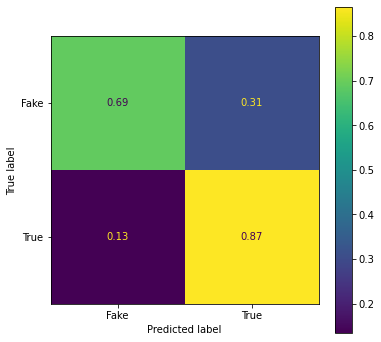

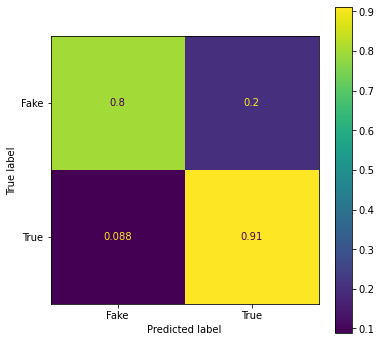

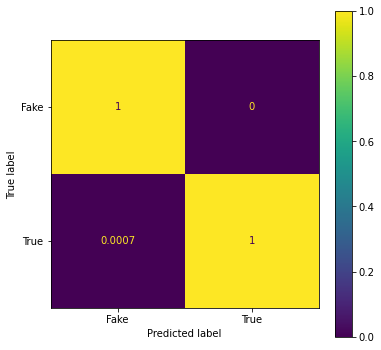

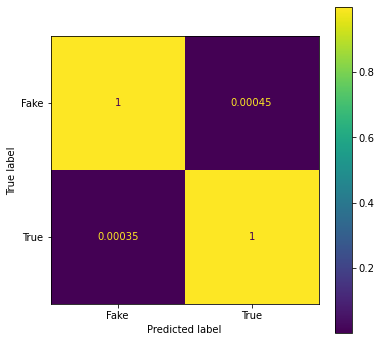

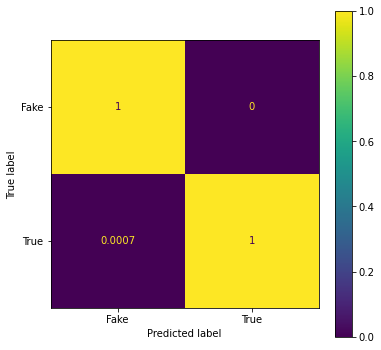

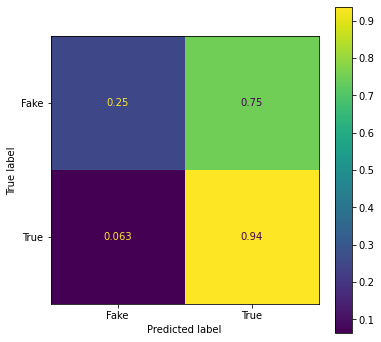

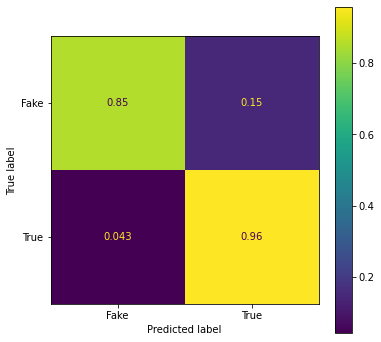

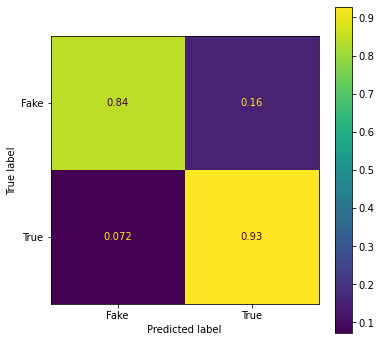

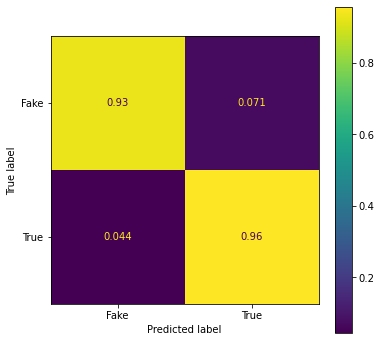

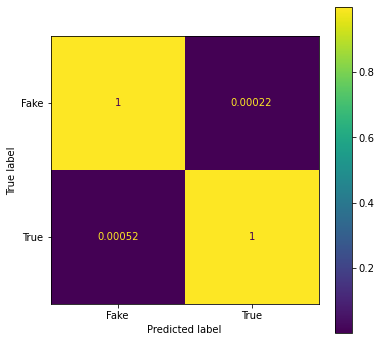

In [207]:
scores1 = cross_validate_models(models1, X_train_clean, y_train_clean, cv=2, cm=True)

In [28]:
scores1

[('MultiNomBa', 0.593359375),
 ('LogisticReg', 0.5814453125000001),
 ('DecTreeClass', 0.56572265625),
 ('RandomFor', 0.5984375),
 ('ExtraTrees', 0.5933593749999999),
 ('GradBoost', 0.58466796875),
 ('SupportVec', 0.6064453125),
 ('StochGrad', 0.55986328125),
 ('PassAgress', 0.54677734375),
 ('MultiLayerPerc', 0.56484375)]

The accuracy of the models range from around 54% to around 60%. The majority of the confusion matrices displayed look really overfit. That's something I'll try to address during the hyperparameter tuning stage.<br />
I'll now use Tfidf vectorizer for the same models to see if there's an improvement.

In [52]:
mnb_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('mnb', MultinomialNB())])

lr_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('LogisticReg', LogisticRegression())])

dtc_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('DecisionTree', DecisionTreeClassifier())])

rf_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('RandomFor', RandomForestClassifier())]) 

etc_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('ExtraTrees', ExtraTreesClassifier())]) 

gbc_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
               ('gradiendboosting', GradientBoostingClassifier())])

svc_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
                ('SupportVec', SVC())])

sgd_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
                ('StochGrad', SGDClassifier())])

pac_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
                ('PassAgress', PassiveAggressiveClassifier())])

mlp_tfidf = Pipeline([('Vectorizer', TfidfVectorizer()),
                ('MultiLayerPerc', MLPClassifier())])

In [53]:
models2 = [('MultiNomBa', mnb_tfidf),
          ('LogisticReg', lr_tfidf),
          ('DecTreeClass', dtc_tfidf),
          ('RandomFor', rf_tfidf),
          ('ExtraTrees', etc_tfidf),
          ('GradBoost', gbc_tfidf),
          ('SupportVec', svc_tfidf),
          ('StochGrad', sgd_tfidf),
          ('PassAgress', pac_tfidf),
          ('MultiLayerPerc', mlp_tfidf)]

In [54]:
scores2 = cross_validate_models(models2, X_train_clean, y_train_clean, cv=2)

In [55]:
scores2

[('MultiNomBa', 0.5951171875000001),
 ('LogisticReg', 0.6005859375),
 ('DecTreeClass', 0.55810546875),
 ('RandomFor', 0.59990234375),
 ('ExtraTrees', 0.5960937500000001),
 ('GradBoost', 0.5801757812499999),
 ('SupportVec', 0.6017578125),
 ('StochGrad', 0.58095703125),
 ('PassAgress', 0.55),
 ('MultiLayerPerc', 0.5570312500000001)]

The accuracy of the models did not increase by changing the vectorizer alone.<br />
Since we have many variables to try in the different models (different hyper parameters, vectorizers and n-gram range), I chose to adapt my function to evaluate a model at a time, but now we can specify those variables as arguments. This should save me time since I won't go through the whole pipeline everytime when wanting to evaluate a model.<br />
I'll also be using the validation data to check the models accuracy from now on.

In [27]:
def cross_validate_model(model_name, vectorizer, X, y, cm=False, params=False, params_rs=False, gs_cv=5, ros=False, ngram_range=(1,1)):
    '''
    Input: Model name (str), Vectorizer (str) X, y
    Optional: confusion matric (cm), gridsearch parameters (params), gridsearch cv (gs_cv),
             random over sampling (ros), ngram range (ngram_range)
    Output: model validation accuracy
    If cm=True, print models confusion matrices. Default=False
    If params, performs gridsearch for best parameters
    If params_rs, performs randomized gridsearch for best parameters
    gs_cv specifies the split of X that will be use to gridsearch and to validate. Default=5
    If ros, performs random over sampling
    ngram_range gives the model which ngram range to use with the vectorizer
                default is for unigrams only (1,1), (1,2) considers unigrams and bigrams,
                (2,2) considers just bigrams, (2,3) considers just bigrams and trigrams...
    '''
    # instantiate model
    if model_name == 'mnb':
        model = MultinomialNB()
    elif model_name == 'lr':
        model = LogisticRegression()
    elif model_name == 'dtc':
        model = DecisionTreeClassifier()
    elif model_name == 'rf':
        model = RandomForestClassifier()
    elif model_name == 'etc':
        model = ExtraTreesClassifier()
    elif model_name == 'gbc':
        model = GradientBoostingClassifier()
    elif model_name == 'svc':
        model = SVC()
    elif model_name == 'sgd':
        model = SGDClassifier()
    elif model_name == 'pac':
        model = PassiveAggressiveClassifier()
    elif model_name == 'mlp':
        model = MLPClassifier()
    
    # create pipeline given vectorizer
    if vectorizer == 'cv':
        pipe = Pipeline([('cv', CountVectorizer(ngram_range=ngram_range)),
               (model_name, model)])
    elif vectorizer == 'tfidf':
        pipe = Pipeline([('tfidf', TfidfVectorizer(ngram_range=ngram_range)),
               (model_name, model)])
    elif vectorizer == 'hash':
        pipe = Pipeline([('hash', HashingVectorizer(ngram_range=ngram_range)),
               (model_name, model)])
    
    # perform random over sampling if ros
    if ros:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(np.array(X).reshape(-1, 1), y)
        X = pd.DataFrame(X).iloc[:,0]
    
    # fit the data
    pipe.fit(X, y) 
    
    # performs gridsearch if params
    if params:
        grid_search = GridSearchCV(pipe, params, cv=gs_cv)
        grid_search.fit(X, y)
        print(model)
        print(grid_search.best_params_)
        
        y_pred = grid_search.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f'Training Accuracy: {round(acc, 4)}')
        y_pred_val = grid_search.predict(X_val_clean)
        acc_val = accuracy_score(y_val_clean, y_pred_val)
        print(f'Validation Accuracy: {round(acc_val, 4)}')
        if cm==True:
            print_cm_with_labels(y, grid_search.predict(X))
    elif params_rs:
        grid_search = RandomizedSearchCV(pipe, params_rs, cv=gs_cv)
        grid_search.fit(X, y)
        print(model)
        print(grid_search.best_params_)
        
        y_pred = grid_search.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f'Training Accuracy: {round(acc, 4)}')
        y_pred_val = grid_search.predict(X_val_clean)
        acc_val = accuracy_score(y_val_clean, y_pred_val)
        print(f'Validation Accuracy: {round(acc_val, 4)}')
        if cm==True:
            print_cm_with_labels(y, grid_search.predict(X))
    else:
        print(model)
        y_pred = pipe.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f'Training Accuracy: {round(acc, 4)}')
        y_pred_val = pipe.predict(X_val_clean)
        acc_val = accuracy_score(y_val_clean, y_pred_val)
        print(f'Validation Accuracy: {round(acc_val, 4)}')        
        if cm==True:
            print_cm_with_labels(y, pipe.predict(X))
    return acc_val

## Baseline Model

The first model I'll use is Logistic Regression. It is a common classification model to classify binary classes, and a good fit for a baseline model. I'll feed it the raw dataset, in which the texts are not processed.

In [178]:
# Change the train data enough so the model can run
baseline_train_df = raw_train.copy()
baseline_train_df = baseline_train_df.dropna(subset=['statement'], axis=0)
baseline_train_df = label(baseline_train_df)
baseline_X_train = baseline_train_df['statement']
baseline_y_train = baseline_train_df['label']

baseline_test_df = raw_test.copy()
baseline_test_df = baseline_test_df.dropna(subset=['statement'], axis=0)
baseline_test_df = label(baseline_test_df)
baseline_X_test = baseline_test_df['statement']
baseline_y_test = baseline_test_df['label']

LogisticRegression()
Training Accuracy: 0.8827
Validation Accuracy: 0.5864


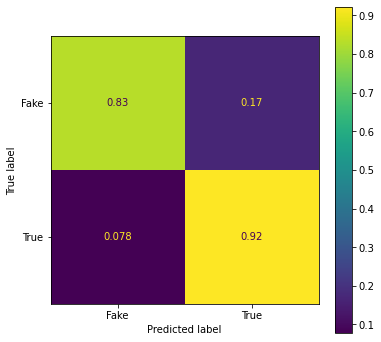

In [208]:
baseline = cross_validate_model('lr', 'cv', baseline_X_train, baseline_y_train, cm=True)

The baseline model has a training accuracy or around 88%, but the cross validation accuracy score is around 58%. That probably means that the model is overfit in the training data. Hyperparameter tuning should help to solve that issue in my newer models.

## Classification Models <a class="anchor" id="Classification"></a>

To improve on the baseline model I'll use the preprocessed data, change the vectorizer, add different n-grams, aplly random over sampling and perform hyperparameter tuning. I'll also run more complex classification models, tune their hyperparameters, and make use of a neural networks in a separate notebook.<br />
For every model I'll chose a variety of variables based on the results from the previous ones and from the hyperparameter tuning.

#### Naive Bayes

In [62]:
mnb_params_1 = [{'mnb__alpha':[.001, .01, .05, .1, .2, .4, .6, .8, 1]}]

Mnb_1 = cross_validate_model('mnb', 'cv', X_train_clean, y_train_clean, params=mnb_params_1)

MultinomialNB()
{'mnb__alpha': 1}
Training Accuracy: 0.7873
Validation Accuracy: 0.6036


In [64]:
Mnb_2 = cross_validate_model('mnb', 'tfidf', X_train_clean, y_train_clean, params=mnb_params_1, ros=True, ngram_range=(1,3))

MultinomialNB()
{'mnb__alpha': 1}
Training Accuracy: 0.9876
Validation Accuracy: 0.6121


There seem to be a lot of improvement that can be gained by fine tuning, but the Naive Bayes model seem to overfit a lot.<br /> Next I'll try with different models.

#### Logistic Regression

In [65]:
lr_params_1 = [{
    'lr__C':[0.001, 0.1, 1],
    'lr__solver':['lbfgs', 'saga', 'newton-cg', 'liblinear', 'sag'],
    'lr__fit_intercept':[True, False],
    'lr__penalty':['l1', 'l2', 'elasticnet', None],
    'lr__class_weight': ['balanced',  None],
}]

lr_1 = cross_validate_model('lr', 'cv', X_train_clean, y_train_clean, params=lr_params_1)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.744
Validation Accuracy: 0.6168


In [232]:
lr_params_2 = [{
    'lr__C':[0.1],
    'lr__solver':['saga'],
    'lr__fit_intercept':[False],
    'lr__penalty':['l2'],
    'lr__class_weight': [None],
}]

In [68]:
lr_2 = cross_validate_model('lr', 'tfidf', X_train_clean, y_train_clean, ros=True, params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.6972
Validation Accuracy: 0.6277


In [69]:
lr_3 = cross_validate_model('lr', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.7763
Validation Accuracy: 0.6324


In [70]:
lr_4 = cross_validate_model('lr', 'hash', X_train_clean, y_train_clean, ros=True, params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.6681
Validation Accuracy: 0.6231


In [71]:
lr_5 = cross_validate_model('lr', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.6977
Validation Accuracy: 0.6207


In [72]:
lr_6 = cross_validate_model('lr', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,3), params=lr_params_2)

LogisticRegression()
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Training Accuracy: 0.7182
Validation Accuracy: 0.6176


For Logistic Regression, the best model uses a tfidf vectorizer with bigram range of (1,2) and ros.

#### Decision Tree Classifier

In [73]:
dtc_params_1 = [{
    'dtc__criterion':['gini', 'entropy'],
    'dtc__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'dtc__ccp_alpha':[.001, .01, .1, .5],
    'dtc__splitter':['random', 'best'],
    'dtc__class_weight': ['balanced',  None]
}]

dtc_1 = cross_validate_model('dtc', 'cv', X_train_clean, y_train_clean, params=dtc_params_1)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0.001, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5933
Validation Accuracy: 0.5732


We can notice a closer proximity between the training and the validation accuracies, suggesting less overfitting of the training data. The number are still very low and need more tuning.

In [74]:
dtc_params_2 = [{
    'dtc__criterion':['entropy'],
    'dtc__max_depth':[16],
    'dtc__ccp_alpha':[0],
    'dtc__splitter':['random'],
    'dtc__class_weight': [None]
}]

In [75]:
dtc_2 = cross_validate_model('dtc', 'tfidf', X_train_clean, y_train_clean, ros=True, params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5993
Validation Accuracy: 0.535


In [76]:
dtc_3 = cross_validate_model('dtc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.6099
Validation Accuracy: 0.546


In [77]:
dtc_4 = cross_validate_model('dtc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,3), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5947
Validation Accuracy: 0.5553


In [78]:
dtc_5 = cross_validate_model('dtc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(2,3), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5341
Validation Accuracy: 0.5405


In [79]:
dtc_6 = cross_validate_model('dtc', 'hash', X_train_clean, y_train_clean, ros=True, params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.6139
Validation Accuracy: 0.5654


In [80]:
dtc_7 = cross_validate_model('dtc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5997
Validation Accuracy: 0.5467


In [81]:
dtc_8 = cross_validate_model('dtc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(1,3), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.6047
Validation Accuracy: 0.5405


In [82]:
dtc_9 = cross_validate_model('dtc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(2,3), params=dtc_params_2)

DecisionTreeClassifier()
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Training Accuracy: 0.5425
Validation Accuracy: 0.5421


The decision tree models don't seem to work really well for this.

#### Random Forest Classifier

Gridsearches are not optimal for this amount of models, so I'll start using Randomized search to save time.

In [83]:
rf_params_1 = [{
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'rf__ccp_alpha':[.001, .01, .1, .5],
    'rf__n_estimators':[100, 500, 1000],
    'rf__class_weight': ['balanced',  None],
    'rf__max_features': ['auto',  'sqrt', 'log2']
}]

rf_1 = cross_validate_model('rf', 'cv', X_train_clean, y_train_clean, params_rs=rf_params_1)

RandomForestClassifier()
{'rf__n_estimators': 500, 'rf__max_features': 'sqrt', 'rf__max_depth': 22, 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced', 'rf__ccp_alpha': 0.001}
Training Accuracy: 0.6419
Validation Accuracy: 0.602


In [84]:
rf_params_2 = [{
    'rf__criterion':['entropy'],
    'rf__max_depth':[22],
    'rf__ccp_alpha':[.001],
    'rf__n_estimators':[500],
    'rf__class_weight': ['balanced'],
    'rf__max_features': ['sqrt']
}]

In [85]:
rf_2 = cross_validate_model('rf', 'cv', X_train_clean, y_train_clean, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.6575
Validation Accuracy: 0.6121


In [86]:
rf_3 = cross_validate_model('rf', 'cv', X_train_clean, y_train_clean, ros=True, params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.6526
Validation Accuracy: 0.6067


In [87]:
rf_4 = cross_validate_model('rf', 'cv', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.6671
Validation Accuracy: 0.6199


In [88]:
rf_5 = cross_validate_model('rf', 'tfidf', X_train_clean, y_train_clean, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.7047
Validation Accuracy: 0.6137


In [89]:
rf_6 = cross_validate_model('rf', 'tfidf', X_train_clean, y_train_clean, ros=True, params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.6825
Validation Accuracy: 0.6067


In [90]:
rf_7 = cross_validate_model('rf', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.708
Validation Accuracy: 0.6129


In [91]:
rf_8 = cross_validate_model('rf', 'hash', X_train_clean, y_train_clean, ngram_range=(1,2), params=rf_params_2)

RandomForestClassifier()
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Training Accuracy: 0.646
Validation Accuracy: 0.6137


For Random Forests, the best model uses count vectorizer, bigram range of (1,2) and ros.

#### Extra Trees Classifier

In [94]:
etc_params_1 = [{
    'etc__criterion':['gini', 'entropy'],
    'etc__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'etc__ccp_alpha':[0, .001, .01, .1, .5],
    'etc__n_estimators':[100, 500, 1000],
    'etc__class_weight': ['balanced',  'balanced_subsample', None],
    'etc__max_features': ['auto',  'sqrt', 'log2']
}]

etc_1 = cross_validate_model('etc', 'cv', X_train_clean, y_train_clean, params_rs=etc_params_1)

ExtraTreesClassifier()
{'etc__n_estimators': 500, 'etc__max_features': 'sqrt', 'etc__max_depth': 16, 'etc__criterion': 'entropy', 'etc__class_weight': 'balanced', 'etc__ccp_alpha': 0}
Training Accuracy: 0.7406
Validation Accuracy: 0.602


In [96]:
etc_params_2 = [{
    'etc__criterion':['entropy'],
    'etc__max_depth':[16],
    'etc__ccp_alpha':[0],
    'etc__n_estimators':[500],
    'etc__class_weight': ['balanced'],
    'etc__max_features': ['sqrt']
}]

In [97]:
etc_2 = cross_validate_model('etc', 'cv', X_train_clean, y_train_clean, ngram_range=(2,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.713
Validation Accuracy: 0.5522


In [98]:
etc_3 = cross_validate_model('etc', 'tfidf', X_train_clean, y_train_clean, ngram_range=(2,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7426
Validation Accuracy: 0.5654


In [395]:
# etc_4 = cross_validate_model('etc', 'hash', X_train_clean, y_train_clean, ngram_range=(2,2), params=etc_params_2)

In [99]:
etc_5 = cross_validate_model('etc', 'cv', X_train_clean, y_train_clean, ngram_range=(1,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7715
Validation Accuracy: 0.6153


In [100]:
etc_6 = cross_validate_model('etc', 'cv', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7725
Validation Accuracy: 0.6114


In [101]:
etc_7 = cross_validate_model('etc', 'tfidf', X_train_clean, y_train_clean, ngram_range=(1,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7959
Validation Accuracy: 0.6106


In [102]:
etc_8 = cross_validate_model('etc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=etc_params_2)

ExtraTreesClassifier()
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Training Accuracy: 0.7887
Validation Accuracy: 0.6083


For extra trees, the best model uses count vectorizer and unigrams and bigrams.

#### Gradient Boosting Classifier

In [103]:
gbc_params_1 = [{
    'gbc__learning_rate':[0.05, 0.1],
    'gbc__n_estimators':[40, 70]
}]

gbc_1 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_1)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.1, 'gbc__n_estimators': 70}
Training Accuracy: 0.6283
Validation Accuracy: 0.5701


In [104]:
gbc_params_2 = [{
    'gbc__learning_rate':[0.05, 0.1],
    'gbc__n_estimators':[70, 100, 500]
}]

gbc_2 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_2)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.05, 'gbc__n_estimators': 500}
Training Accuracy: 0.6818
Validation Accuracy: 0.5911


In [105]:
gbc_params_3 = [{
    'gbc__learning_rate':[0.005, 0.01],
    'gbc__n_estimators':[500, 1000]
}]

gbc_3 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_3)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.01, 'gbc__n_estimators': 1000}
Training Accuracy: 0.6373
Validation Accuracy: 0.5709


In [106]:
gbc_params_4 = [{
    'gbc__learning_rate':[0.001, 0.01],
    'gbc__n_estimators':[1000, 2000]
}]

gbc_4 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_4)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.01, 'gbc__n_estimators': 2000}
Training Accuracy: 0.6655
Validation Accuracy: 0.5841


In [107]:
gbc_params_5 = [{
    'gbc__learning_rate':[0.02, 0.01],
    'gbc__n_estimators':[3000, 2000]
}]

gbc_5 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_5)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.02, 'gbc__n_estimators': 2000}
Training Accuracy: 0.7136
Validation Accuracy: 0.5997


In [108]:
gbc_params_6 = [{
    'gbc__learning_rate':[0.02],
    'gbc__n_estimators':[2000],
    'gbc__loss':['deviance', 'exponential'],
    'gbc__max_features': ['sqrt',  'log2', None]
}]

gbc_6 = cross_validate_model('gbc', 'cv', X_train_clean, y_train_clean, params=gbc_params_6)

GradientBoostingClassifier()
{'gbc__learning_rate': 0.02, 'gbc__loss': 'deviance', 'gbc__max_features': None, 'gbc__n_estimators': 2000}
Training Accuracy: 0.713
Validation Accuracy: 0.6036


Gradient Boosting isn't increasing our validation accuracy

#### C-Support Vector Classification

In [113]:
svc_params_1 = [{
    'svc__C':[0.5, 1, 1.5],
    'svc__shrinking':[True, False]
}]

svc_1 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, params_rs=svc_params_1)

SVC()
{'svc__shrinking': True, 'svc__C': 1}
Training Accuracy: 0.91
Validation Accuracy: 0.6254


In [114]:
svc_params_2 = [{
    'svc__C':[1],
    'svc__gamma':['scale', 'auto'],
    'svc__tol':[0.001, 0.0001],
    'svc__shrinking':[True]
}]

svc_2 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, params_rs=svc_params_2)

SVC()
{'svc__tol': 0.001, 'svc__shrinking': True, 'svc__gamma': 'scale', 'svc__C': 1}
Training Accuracy: 0.91
Validation Accuracy: 0.6254


In [115]:
svc_params_3 = [{
    'svc__C':[1],
    'svc__gamma':['scale'],
    'svc__tol':[0.01, 0.001],
    'svc__shrinking':[True],
    'svc__class_weight': ['balanced', None]
}]

svc_3 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, params_rs=svc_params_3)

SVC()
{'svc__tol': 0.001, 'svc__shrinking': True, 'svc__gamma': 'scale', 'svc__class_weight': None, 'svc__C': 1}
Training Accuracy: 0.91
Validation Accuracy: 0.6254


In [116]:
svc_params_4 = [{
    'svc__C':[1],
    'svc__gamma':['scale'],
    'svc__tol':[0.001,],
    'svc__shrinking':[True],
    'svc__class_weight': [None]
}]

In [117]:
svc_4 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, ros=True, params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9292
Validation Accuracy: 0.6168


In [118]:
svc_5 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, ros=True, ngram_range=(1,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9625
Validation Accuracy: 0.6246


In [119]:
svc_6 = cross_validate_model('svc', 'cv', X_train_clean, y_train_clean, ros=True, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9895
Validation Accuracy: 0.5958


In [120]:
svc_7 = cross_validate_model('svc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9988
Validation Accuracy: 0.5919


In [121]:
svc_8 = cross_validate_model('svc', 'tfidf', X_train_clean, y_train_clean, ros=True, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9987
Validation Accuracy: 0.5888


In [122]:
svc_9 = cross_validate_model('svc', 'hash', X_train_clean, y_train_clean, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.995
Validation Accuracy: 0.574


In [123]:
svc_10 = cross_validate_model('svc', 'hash', X_train_clean, y_train_clean, ros=True, ngram_range=(2,2), params=svc_params_4)

SVC()
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.001}
Training Accuracy: 0.9969
Validation Accuracy: 0.5771


The best svc model uses count vectorizer, unigrams and has a validation accuracy of around 62.54%.

#### Stochastic Gradient Descent Classifier

In [124]:
sgd_params_1 = [{
    'sgd__loss':['hinge', 'log'],
    'sgd__alpha':[0.01, 0.001, 0.0001],
    'sgd__early_stopping': [True]
}]

sgd_1 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, params=sgd_params_1)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__loss': 'hinge'}
Training Accuracy: 0.6495
Validation Accuracy: 0.6121


In [125]:
sgd_params_2 = [{
    'sgd__loss':['log'],
    'sgd__penalty':['l1', 'l2'],
    'sgd__alpha':[0.1, 0.01],
    'sgd__early_stopping': [True]
}]

sgd_2 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, params=sgd_params_2)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6617
Validation Accuracy: 0.6207


In [126]:
sgd_params_3 = [{
    'sgd__loss':['log'],
    'sgd__penalty':['l2'],
    'sgd__alpha':[0.01],
    'sgd__fit_intercept':[True, False],
    'sgd__learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'],
    'sgd__early_stopping': [True]
}]

sgd_3 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, params=sgd_params_3)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6616
Validation Accuracy: 0.6238


In [127]:
sgd_params_4 = [{
    'sgd__loss':['log'],
    'sgd__penalty':['l2'],
    'sgd__alpha':[0.01],
    'sgd__fit_intercept':[False],
    'sgd__learning_rate': ['optimal'],
    'sgd__early_stopping': [True]
}]

sgd_4 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.662
Validation Accuracy: 0.6285


In [128]:
sgd_5 = cross_validate_model('sgd', 'tfidf', X_train_clean, y_train_clean, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6274
Validation Accuracy: 0.5724


In [129]:
sgd_6 = cross_validate_model('sgd', 'hash', X_train_clean, y_train_clean, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6213
Validation Accuracy: 0.5896


In [130]:
sgd_7 = cross_validate_model('sgd', 'tfidf', X_train_clean, y_train_clean, ros=True, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6627
Validation Accuracy: 0.6254


In [131]:
sgd_8 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, ros=True, params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.6633
Validation Accuracy: 0.6207


In [132]:
sgd_9 = cross_validate_model('sgd', 'tfidf', X_train_clean, y_train_clean, ngram_range=(1,2), params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.672
Validation Accuracy: 0.5818


In [133]:
sgd_10 = cross_validate_model('sgd', 'cv', X_train_clean, y_train_clean, ngram_range=(1,2), params=sgd_params_4)

SGDClassifier()
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Training Accuracy: 0.7182
Validation Accuracy: 0.6269


The best validation accuracy for SGD classifier is 62.85%, and is from a model with cv as vectorizer and uses unigrams only.

#### Passive Aggressive Classifier

In [134]:
pac_params_1 = [{
    'pac__C':[0.5, 1.0, 1.5, 2.0],
    'pac__fit_intercept':[True,False]
}]

pac_1 = cross_validate_model('pac', 'cv', X_train_clean, y_train_clean, params=pac_params_1)

PassiveAggressiveClassifier()
{'pac__C': 1.5, 'pac__fit_intercept': True}
Training Accuracy: 0.9261
Validation Accuracy: 0.56


In [135]:
pac_params_2 = [{
    'pac__C':[1.5],
    'pac__fit_intercept':[True],
    'pac__class_weight': ['balanced', None],
    'pac__average': [True, False, 5, 10]
}]

pac_2 = cross_validate_model('pac', 'cv', X_train_clean, y_train_clean, params=pac_params_2)

PassiveAggressiveClassifier()
{'pac__C': 1.5, 'pac__average': 10, 'pac__class_weight': None, 'pac__fit_intercept': True}
Training Accuracy: 0.9536
Validation Accuracy: 0.5561


It doesn't seem like the valdiation accuracy will improve for these models, so I'll stop the tuning here.

# Embedding <a class="anchor" id="Embedding"></a>

Word embedding in NLP consists in adding meaning to a word by breaking it down into n-dimensional vectors in such a way that vectors that are close in that space share meaning or context. I've done exploration of several techniques using word embeddings, starting with Word2Vec and Glove, which can be found on the [Word2Vec, Glove and Doc2Vec Notebook](Word2Vec_Golve_Doc2Vec.ipynb). I then proceeded to utilize a Keras Layer for embedding purposes, and the results are in the [Keras Embedding Notebook](Keras_Embedding.ipynb). From there I went on to explorer more robust word embeddings, and used Googles nnlm embedding in several neural networks models. This work is show in the [Google nnlm Embedding Notebook](Google_nnlm_Embedding.ipynb). Lastly I went to pursuit newer techniques, that allow for sentence embedding. Here I used of many pre-trained models using keras layers or tensorflow hub to apply them to my neural networks. The results are in the [Sentence Embedding Notebook](Sentence_Embedding.ipynb).

## Latent Dirichlet Analisys <a class="anchor" id="lda"></a>

Although LDA is a great tool for visualizing topics and understending how they're formed within a corpus, it did not offered much in terms of helping forr fake news detection. Given the number of actual subjects contained in the dataset, I chose to visualize a o topic split of two, and of eight topics, and I did so with all words in the whole dataset, and also with them split in statements that are true and that are fake. The results of the latter are very overlapping and not really insightful for our subject. Nonetheless, the exploration can be found in the [LDA Notebook](LDA.ipynb).

# III. Final Model <a class="anchor" id="Final_Model"></a>

The model that achieved the highest accuracy is the one using sentence embedding, which reached a validation accuracy of around 65% and a test accuracy of 61%. To reproduce it in this notebook I'll re-preprocess the data, since the preprocessing for sentence embedding is different from the one used in this notebook so far. This model was the last compiled model in the [Sentence Embedding Notebook](Sentence_Embedding.ipynb).<br />
After I reproduced it, however, I noticed a drop in validation and test accuracy, which made it match one of my earlier Logistic Regression models tuned models. Because of that I'll also be looking at Precision to judge which model is better.

### Neural Networks

In [32]:
def lower_case(df):
    df['statement'] = df['statement'].apply(lambda x: x.lower())
    return df

In [33]:
final_cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    ('drop_features', FunctionTransformer(drop_features)),
    ('lower_case', FunctionTransformer(lower_case))
])

In [34]:
df_train_final = final_cleaning_pipeline.fit_transform(raw_train)
df_val_final = final_cleaning_pipeline.transform(raw_val)
df_test_final = final_cleaning_pipeline.transform(raw_test)

In [35]:
# Creates X variable and y target for all data
X_train_final = df_train_final['statement']
y_train_final = df_train_final['label']
X_val_final = df_val_final['statement']
y_val_final = df_val_final['label']
X_test_final = df_test_final['statement']
y_test_final = df_test_final['label']

In [40]:
# One hot encode y_values
le = LabelEncoder()

train_labels = le.fit_transform(y_train_final)
val_labels = le.transform(y_val_final)
test_labels = le.transform(y_test_final)

train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))
val_labels = np.asarray(tf.keras.utils.to_categorical(val_labels))
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

In [170]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [171]:
# convert sentences to embeddings
X_train = embed(X_train_final)
X_val = embed(X_val_final)
X_test = embed(X_test_final)

In [172]:
final_model = Sequential()
final_model.add(Dense(units=32, activation="relu"))
final_model.add(Dense(units=64, activation="relu"))
final_model.add(Dropout(0.1))
final_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
final_model.add(Dropout(0.1))
final_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
final_model.add(Dense(units=2, activation="sigmoid"))

In [173]:
filepath = 'final_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

final_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

history = final_model.fit(X_train, train_labels,
              epochs=200,
              validation_data=(X_val, val_labels),
              batch_size=64,
              verbose=1,
              callbacks=callbacks)

Epoch 1/200
147/160 [==========================>...] - ETA: 0s - loss: 12.7462 - accuracy: 0.5301
Epoch 1: val_accuracy improved from -inf to 0.52025, saving model to final_model.hdf5
160/160 [==============================] - 9s 29ms/step - loss: 12.6924 - accuracy: 0.5329 - val_loss: 12.0302 - val_accuracy: 0.5202
Epoch 2/200
146/160 [==========================>...] - ETA: 0s - loss: 11.4694 - accuracy: 0.5614
Epoch 2: val_accuracy did not improve from 0.52025
160/160 [==============================] - 1s 5ms/step - loss: 11.4173 - accuracy: 0.5617 - val_loss: 10.8247 - val_accuracy: 0.5202
Epoch 3/200
152/160 [===========================>..] - ETA: 0s - loss: 10.2970 - accuracy: 0.5603
Epoch 3: val_accuracy did not improve from 0.52025
160/160 [==============================] - 0s 3ms/step - loss: 10.2701 - accuracy: 0.5617 - val_loss: 9.7385 - val_accuracy: 0.5202
Epoch 4/200
141/160 [=========================>....] - ETA: 0s - loss: 9.2934 - accuracy: 0.5618
Epoch 4: val_accuracy 

In [55]:
def plot_accuracy(history):
    '''
    Input: Hisotry of Neural Network model
    Prints: Training and validation accuracies
    Output: None
    '''
    plt.plot(history.history['accuracy'], label='training data')
    plt.plot(history.history['val_accuracy'], label='validation data')
    plt.title('Categorical Accuracy for Text Classification')
    plt.ylabel('Categorical Accuracy Value')
    plt.xlabel('No. epoch')
    plt.legend(loc='upper left')
    plt.show()
    return None

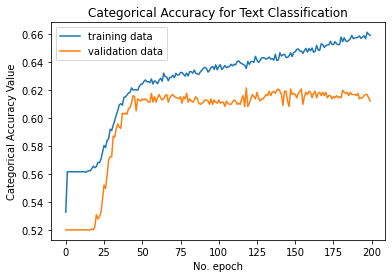

In [174]:
plot_accuracy(history)

In [211]:
def evaluate_nn_model(filepath, X, y):
    '''
    Input: Model in hdf5 form file path, X and y values
    Output: Model accuracy score
    '''
    model = load_model(filepath)
    yhat = model.predict(X)
    y_pred = [0 if p[0] > 0.5 else 1 for p in yhat]
    y_true = [0 if p[0] > 0.5 else 1 for p in y]
    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred)

In [216]:
val_acc, val_prec = evaluate_nn_model(filepath, X_val, val_labels)
print(f'NN Validation Accuracy: {round(val_acc, 4)}')
print(f'NN Validation Precision: {round(val_prec, 4)}')

NN Validation accuracy: 0.6199
NN Validation precision: 0.622


In [217]:
test_acc, test_prec = evaluate_nn_model(filepath, X_test, test_labels)
print(f'NN Test Accuracy: {round(test_acc, 4)}')
print(f'NN Test Precision: {round(test_prec, 4)}')

NN Test Accuracy: 0.6133
NN Test Precision: 0.6474


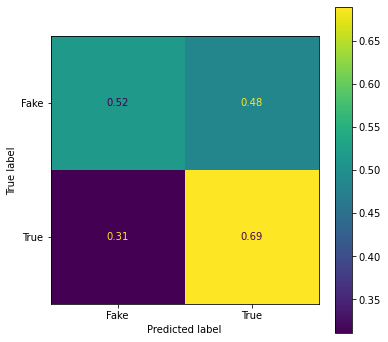

In [219]:
# Neural Network Confusion Matrix
final_model__ = load_model(filepath)
y_pred = final_model__.predict(X_test)
y_pred =  [0 if p[0] > 0.5 else 1 for p in y_pred]
print_cm_with_labels(y_test_clean, y_pred)

### Logistic Regression

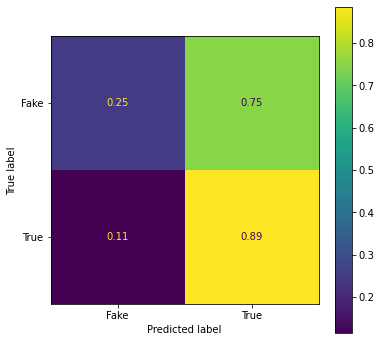

In [220]:
final_pipe = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),
               ('Log_Reg', LogisticRegression(C=0.1, solver='saga', fit_intercept=False))])
final_pipe.fit(X_train_clean, y_train_clean)
print_cm_with_labels(y_test_clean, final_pipe.predict(X_test_clean))

In [222]:
lr_test_acc = accuracy_score(y_test_clean, final_pipe.predict(X_test_clean))
lr_test_prec = precision_score(y_test_clean, final_pipe.predict(X_test_clean))

In [223]:
print(f'Logistic Regression Test Accuracy: {round(lr_test_acc, 4)}')
print(f'Logistic Regression Test Precision: {round(lr_test_prec, 4)}')

Logistic Regression Test Accuracy: 0.6093
Logistic Regression Test Precision: 0.6048


# IV. Results <a class="anchor" id="Results"></a>

The test accuracy for the Tuned Logistic Regression ended up falling significantly compared with the validation. That, combined with the fact that the Neural Network Embedding model also reached a higher Precision made me choose the Neural Network model as my final one. It has a Test Accuracy of around 62% and a Test Precision of around 65%.<br />
It's interesting to note that, regarding True news, the model can correctly label around 70% of them, labeling around 30% of them incorrectly as fake, but regarding Fake news, the model works no better than a random guess. Finding the underlying semantic structure in news designed to decieve readers is a very challenging task, and this work needs to be continued with even more state of the art techniques or more information.

### Visualizations <a class="anchor" id="Visualizations"></a>

In [231]:
accuracy_graph = {'Baseline': 58.02, 'Bayes        \ntfidf-ngram(1,3)': 61.21, 'Logistic Regression\ntfidf-ngram(1,2)  ': 63.24,
               'Decision Tree    \nhash-ngram(1,1)': 56.54, 'Random Forest\ncv-ngram(1,2)': 61.99, 'Extra Trees    \ncv-ngram(1,2)': 61.53,
               'Gradient Boost\ncv-ngram(1,1)': 60.36, 'SVC        \ncv-ngram(1,1)': 62.54, 'SGD         \ncv-ngram(1,1)': 62.85}

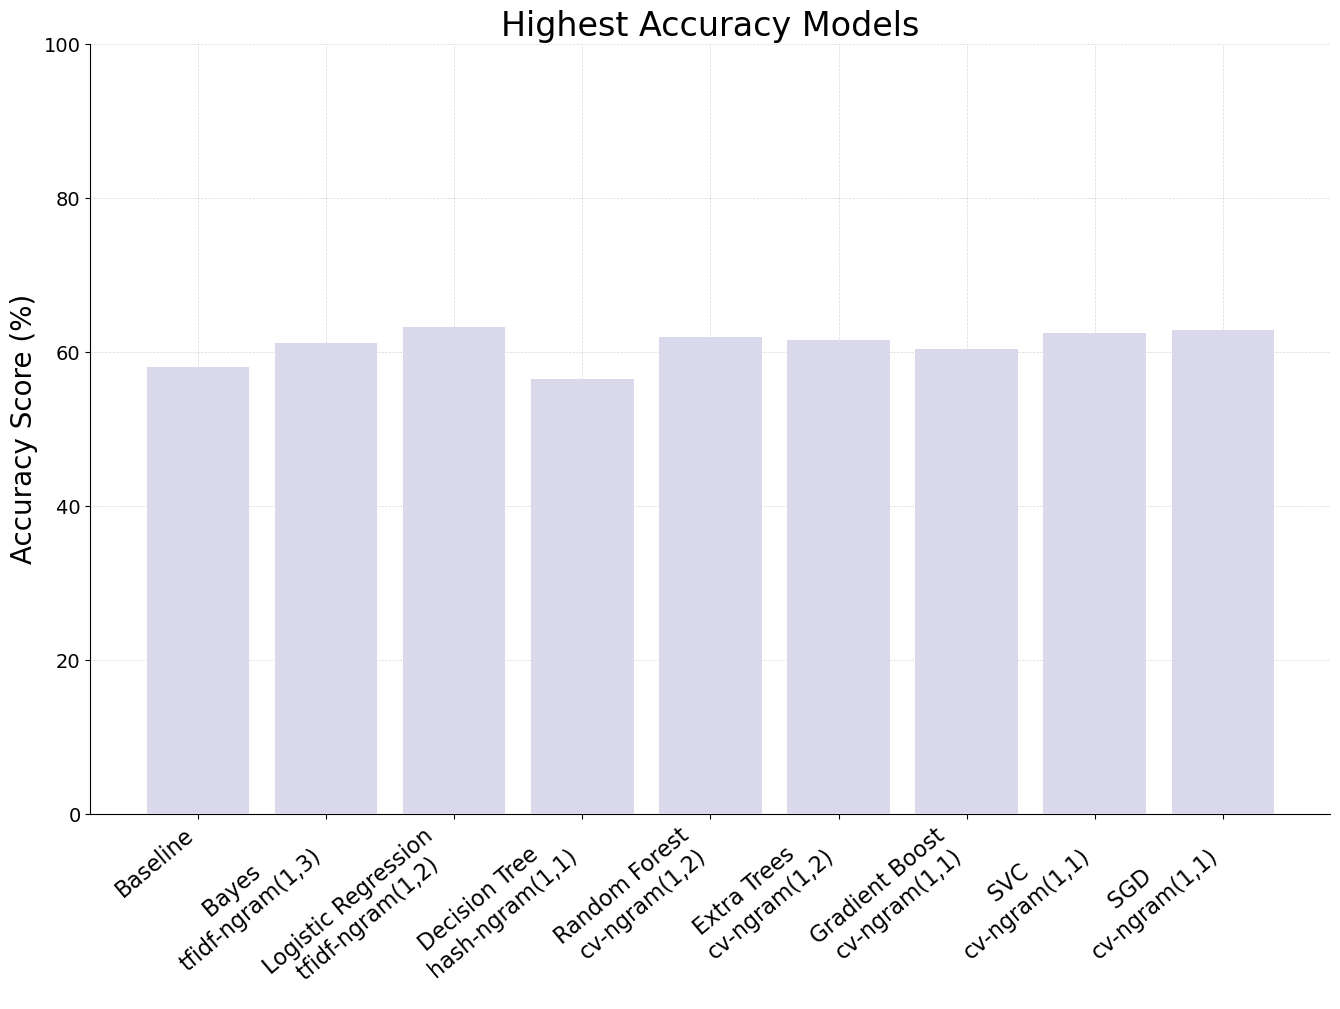

In [246]:
# Visualize the chages from baseline to tuned models
plt.style.use('default')

fig, ax = plt.subplots(figsize=(16, 10))

c = ['#d9d9eb' for item in accuracy_graph.items()]

model_names = [model_name for model_name, value in accuracy_graph.items()]
model_scores = [value for model_name, value in accuracy_graph.items()]

plt.bar(model_names, model_scores, color=c, zorder=3)

ax.set_title('Highest Accuracy Models', fontsize=24)
plt.xticks(rotation=40, ha='right', fontsize=16)
plt.yticks(fontsize=14)
ax.set_ylabel('Accuracy Score (%)', fontsize=20)
ax.set_ylim(top=100)
sns.despine(fig)

plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

# plt.savefig('./images/skyler_graph_01', bbox_inches='tight')

In [251]:
accuracy_graph_02 = {'Keras Tokenizer \nSimple       ': 52.85,  'Keras Tokenizer \n Tuned       ': 59.03, 'Word2Vec': 62.23, 
                     'Doc2Vec': 54.51, 'Google \n   nnlm-en': 62.85, 'Universal       \nSentence Encoder': 64.72}

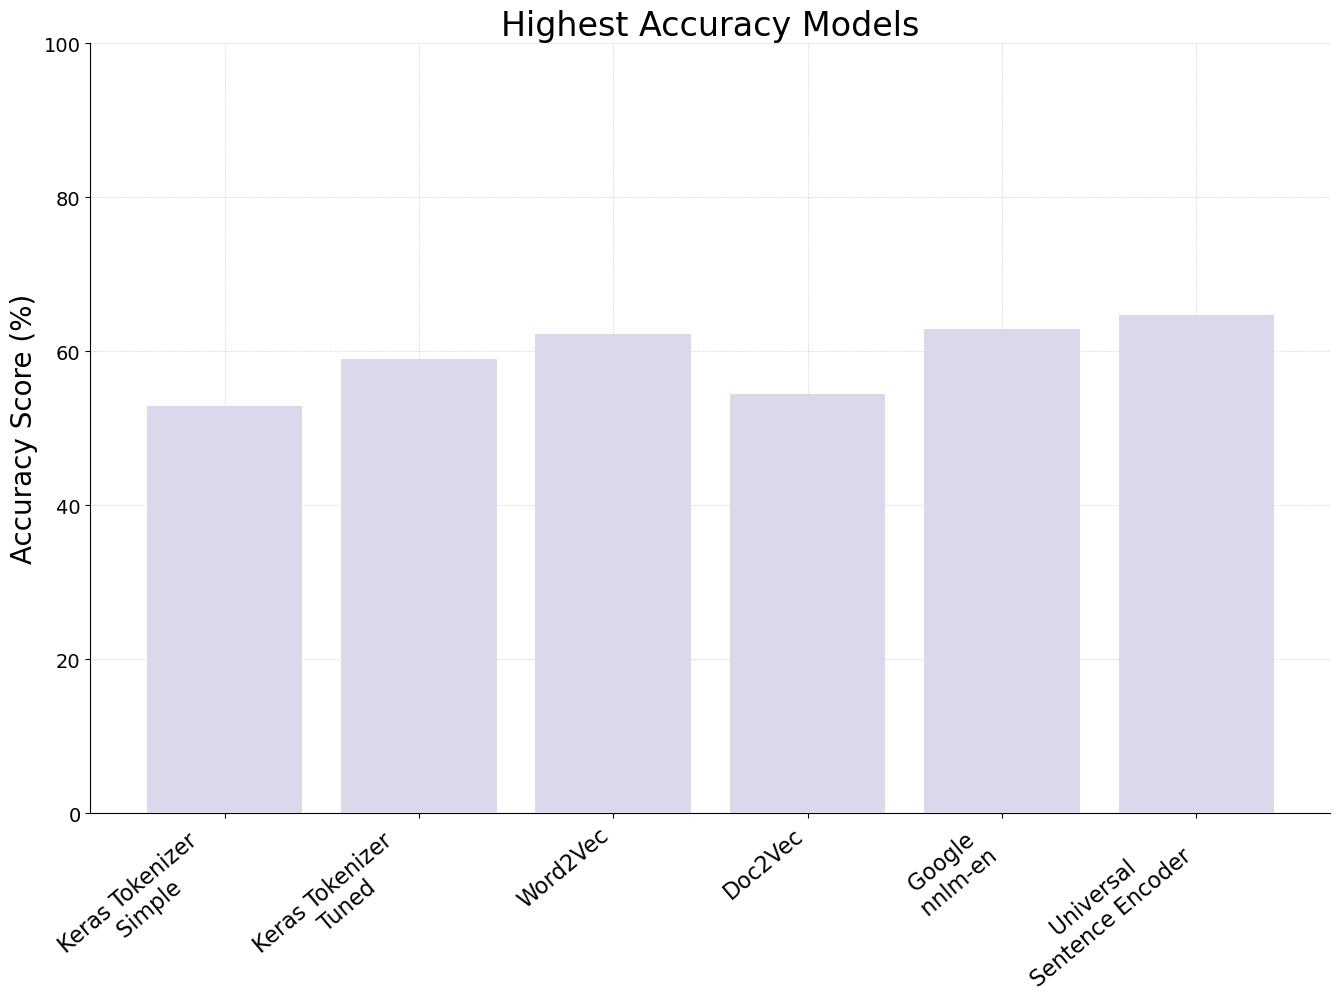

In [253]:
# Visualize the chages from baseline to tuned models
plt.style.use('default')

fig, ax = plt.subplots(figsize=(16, 10))

c = ['#d9d9eb' for item in accuracy_graph_02.items()]

model_names_nn = [model_name for model_name, value in accuracy_graph_02.items()]
model_scores_nn = [value for model_name, value in accuracy_graph_02.items()]

plt.bar(model_names_nn, model_scores_nn, color=c, zorder=3)

ax.set_title('Highest Accuracy Models', fontsize=24)
plt.xticks(rotation=40, ha='right', fontsize=16)
plt.yticks(fontsize=14)
ax.set_ylabel('Accuracy Score (%)', fontsize=20)
ax.set_ylim(top=100)
sns.despine(fig)

plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)
# plt.savefig('./images/skyler_graph_02', bbox_inches='tight')

## Next Steps <a class="anchor" id="Next_Steps"></a>

For further development, I propose:
* Use the Metadata
  - The person making the statement, their political affiliation,  other characteristics may affect how the model operates. If we have that information for new statements, it could give us a more accurate classification
* Use more embedding techniques
  - I won't go through again all the techniques I used in this work, but there are still many more that could be use to embed the data and could potentially lead to better results. To name a few, we have: Bert, InferSent, ELMo, other Universal Sentence Encoders, and more
* Create models for different languages
  - Different languages have different semantic structures. If this model is to be reproduced for a different language, we'd need fo find pre-trained embeddings in that language to use in our vocabulary

# Contact <a class="anchor" id="Contact"></a>

For any further questions, feel free to reach me:

#### Marcelo Scatena
marcelo.oddo@gmail.com<br />
[Github](https://github.com/moscatena)<br />
[LinkedIn](https://www.linkedin.com/in/marcelo-scatena/)

##### References:<br />
Reimche, Roman. (2018). [Comparison of the diffusion of real and fake news in social networks](https://www.researchgate.net/publication/322203544_Comparison_of_the_diffusion_of_real_and_fake_news_in_social_networks).. 10.13140/RG.2.2.35221.22243. <br />
[“Liar, Liar Pants on Fire”: A New Benchmark Dataset for Fake News Detection](https://aclanthology.org/P17-2067) (Wang, ACL 2017)<br />
[Where is Your Evidence: Improving Fact-checking by Justification Modeling](https://aclanthology.org/W18-5513) (Alhindi et al., 2018)<br />
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/).
